Portfolio Optimisation Notebook
-
### Authors: Amelia Yamato Leow Mei Li (A0208055L), Kevin Tan YueJun (A0218074H)


##### This jupyternotebook provides viewers with the code that was used to generate and optimise our portfolio of SGX securities. The objective of this program is to perform portfolio optimization techniques and constructed a diversified portfolio that maximizes Sharpe Ratio. It can be divided into the following sections:

- Section 1: Import Libraries and Dependencies
- Section 2: Yfinance Data (API)

    > Section 2.1: Parameter Initialisation
    
    > Section 2.2: Historical Data Collection

- Section 3: PyPortfolioOpt

    > Section 3.1 Mean-Variance Optimisation
    
    > Section 3.2 Portfolio Performance using MVO

- Section 4: Backtesting

    > Section 4.1: Approach A (Log Return Calculation)

    > Section 4.1: Approach B (Discrete Allocation and Portfolio Valuation)

- Section 5: Sector Constraints

    > Section 5.1: (Experiment 1) Fully Diversified Portfolio

    > Section 5.2: (Experiment 2) Growth-Oriented Portfolio

    > Section 5.3: (Experiment 3) Defensive Portfolio

- Section 6: Portfolio Performance Evaluation

    > Section 6.1: Benchmark Metrics

    > Section 6.2: Performance Plot (Portfolios vs Benchmark)

### Section 1: Import Libraries and Dependencies

In [1]:
!pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.4 MB/s eta 0:00:00


In [2]:
# Import relevant libraries
import pandas as pd
import numpy as np
import yfinance as yf
import math
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

### Section 2: Yfinance Data (API)

#### Section 2.1: Parameter Initialisation

In [3]:
stocks = [
    'D05.SI',   # DBS Group Holdings Ltd.
    'O39.SI',   # Oversea-Chinese Banking Corp Limited
    'U11.SI',   # United Overseas Bank Limited
    'C38U.SI',  # CapitaLand Integrated Commercial Trust
    'C6L.SI',   # Singapore Airlines Limited
    'S63.SI',   # ST Engineering
    'F34.SI',   # Wilmar International Limited
    'A17U.SI',  # Ascendas Real Estate Investment Trust
    'Z74.SI',   # Singapore Telecommunications Limited
    'BN4.SI',   # Keppel Corporation Limited
    'G13.SI',   # Genting Singapore PLC
    'C52.SI',   # ComfortDelgro Corporation Limited
    'BS6.SI',   # Yangzijiang Shipbuilding (Holdings) Ltd
    'S68.SI',   # Singapore Exchange Limited
    'Y92.SI',   # Thai Beverage Public Co Ltd
    'C09.SI'    # City Developments Limited
]

portfolio_value = 1000000
train_start = '2015-01-01' # Train
train_end = '2022-12-31' # Train
backtesting_start = '2023-01-01' # Test
backtesting_end = '2023-11-01' # Test

benchmark = 'ES3.SI' # Benchmark for portfolio evaluation

#### Section 2.2: Historical Data Collection

In [4]:
def closing_price_dataframe(stocks, start, end):
    stock_df = pd.DataFrame()
    for stock in stocks:
        try:
            # Close column in yf.Ticker function corresponds to adjusted closing price in yf.download function
            stock_df[f'{stock}'] = yf.Ticker(stock).history(start=start, end=end).Close
        except:
            print(f'{stock} was not found')

    # Handle the datetime index
    stock_df.index = stock_df.index.strftime('%Y-%m-%d')
    return stock_df

In [5]:
stocks_data = closing_price_dataframe(stocks, train_start, train_end)
stocks_data.head()

,D05.SI,O39.SI,U11.SI,C38U.SI,C6L.SI,S63.SI,F34.SI,A17U.SI,Z74.SI,BN4.SI,G13.SI,C52.SI,BS6.SI,S68.SI,Y92.SI,C09.SI
Date,,,,,,,,,,,,,,,,
2015-01-02,13.822886,7.215528,17.721079,1.303257,9.779653,2.285370,2.431842,1.437639,2.709047,6.068273,0.841017,1.851055,0.838603,5.508422,0.002571,9.268414
2015-01-05,13.512714,7.112448,17.323425,1.309645,9.813520,2.271966,2.402094,1.443628,2.702082,5.951838,0.829227,1.836924,0.866326,5.479956,0.002516,9.079447
2015-01-06,13.371114,6.981882,16.860695,1.290480,9.889728,2.225051,2.372347,1.419668,2.674226,5.698422,0.809577,1.843990,0.859395,5.423021,0.002516,9.070446
2015-01-07,13.350886,6.995626,16.947456,1.328811,10.126810,2.245158,2.357473,1.437639,2.688154,5.718971,0.801717,1.822794,0.887117,5.487073,0.002607,9.016459
2015-01-08,13.539686,7.215528,17.366802,1.296868,10.177615,2.251859,2.409531,1.437639,2.743867,5.801159,0.809577,1.815729,0.880187,5.565359,0.002607,9.286409


### Section 3: PyPortfolioOpt

**Deriving the mean**

In [6]:
mean = mean_historical_return(stocks_data)
print("Mean of given stocks:")
mean

Mean of given stocks:


D05.SI     0.111208
O39.SI     0.059447
U11.SI     0.063990
C38U.SI    0.050844
C6L.SI    -0.073430
S63.SI     0.043575
F34.SI     0.064103
A17U.SI    0.076724
Z74.SI    -0.010518
BN4.SI     0.016403
G13.SI     0.011654
C52.SI    -0.055082
BS6.SI     0.057054
S68.SI     0.056944
Y92.SI     1.005951
C09.SI    -0.016936
dtype: float64

**Deriving the covariance**

In [7]:
covariance = CovarianceShrinkage(stocks_data).ledoit_wolf()
print("Covariance of given stocks:")
covariance

Covariance of given stocks:


,D05.SI,O39.SI,U11.SI,C38U.SI,C6L.SI,S63.SI,F34.SI,A17U.SI,Z74.SI,BN4.SI,G13.SI,C52.SI,BS6.SI,S68.SI,Y92.SI,C09.SI
D05.SI,0.055023,0.021330,0.022251,0.011647,0.015689,0.014248,0.013687,0.010702,0.013451,0.018216,0.019292,0.015432,0.014973,0.011304,0.016931,0.019441
O39.SI,0.021330,0.048855,0.020377,0.011840,0.014815,0.014065,0.014431,0.010913,0.012652,0.018222,0.018187,0.014399,0.013095,0.011563,0.009270,0.019208
U11.SI,0.022251,0.020377,0.051160,0.011123,0.015579,0.014396,0.013493,0.010518,0.012718,0.018178,0.017848,0.015266,0.014964,0.011535,0.011100,0.019316
C38U.SI,0.011647,0.011840,0.011123,0.061333,0.013900,0.013647,0.011895,0.020678,0.011309,0.011311,0.014519,0.013329,0.008269,0.007922,0.016389,0.018240
C6L.SI,0.015689,0.014815,0.015579,0.013900,0.073696,0.014671,0.011935,0.011151,0.012787,0.013162,0.017938,0.016279,0.013556,0.009941,0.012892,0.019122
S63.SI,0.014248,0.014065,0.014396,0.013647,0.014671,0.056853,0.014450,0.012250,0.012184,0.014926,0.016524,0.015576,0.012065,0.011679,0.019441,0.017949
F34.SI,0.013687,0.014431,0.013493,0.011895,0.011935,0.014450,0.066567,0.011692,0.011637,0.017294,0.016291,0.013528,0.014758,0.011017,0.008439,0.017022
A17U.SI,0.010702,0.010913,0.010518,0.020678,0.011151,0.012250,0.011692,0.055577,0.011089,0.010945,0.013029,0.011813,0.009355,0.009709,0.013070,0.016500
Z74.SI,0.013451,0.012652,0.012718,0.011309,0.012787,0.012184,0.011637,0.011089,0.051120,0.013626,0.013826,0.012351,0.009373,0.010324,0.010774,0.014310
BN4.SI,0.018216,0.018222,0.018178,0.011311,0.013162,0.014926,0.017294,0.010945,0.013626,0.068830,0.019579,0.014852,0.019730,0.012788,0.017730,0.021326


#### Section 3.1: Mean Variance Optimisation

In [8]:
print('Running Portfolio Optimisation Process')
eff_front = EfficientFrontier(mean, covariance)
weights = eff_front.max_sharpe()

print('\nWeights: \n')
for symbol, weight in weights.items():
    print(f"Symbol: {symbol}, Weight: {weight}")

Running Portfolio Optimisation Process

Weights: 

Symbol: D05.SI, Weight: 0.3723379250170117
Symbol: O39.SI, Weight: 0.0
Symbol: U11.SI, Weight: 0.0
Symbol: C38U.SI, Weight: 0.0
Symbol: C6L.SI, Weight: 0.0
Symbol: S63.SI, Weight: 0.0
Symbol: F34.SI, Weight: 0.0548730364992298
Symbol: A17U.SI, Weight: 0.1544707800340871
Symbol: Z74.SI, Weight: 0.0
Symbol: BN4.SI, Weight: 0.0
Symbol: G13.SI, Weight: 0.0
Symbol: C52.SI, Weight: 0.0
Symbol: BS6.SI, Weight: 0.0179008412906327
Symbol: S68.SI, Weight: 0.0525466388669398
Symbol: Y92.SI, Weight: 0.3478707782920989
Symbol: C09.SI, Weight: 0.0


In [9]:

cleaned_weights = eff_front.clean_weights()

print('\nCleaned Weights: \n')
for symbol, weight in cleaned_weights.items():
    print(f"Symbol: {symbol}, Cleaned Weight: {weight}")


Cleaned Weights: 

Symbol: D05.SI, Cleaned Weight: 0.37234
Symbol: O39.SI, Cleaned Weight: 0.0
Symbol: U11.SI, Cleaned Weight: 0.0
Symbol: C38U.SI, Cleaned Weight: 0.0
Symbol: C6L.SI, Cleaned Weight: 0.0
Symbol: S63.SI, Cleaned Weight: 0.0
Symbol: F34.SI, Cleaned Weight: 0.05487
Symbol: A17U.SI, Cleaned Weight: 0.15447
Symbol: Z74.SI, Cleaned Weight: 0.0
Symbol: BN4.SI, Cleaned Weight: 0.0
Symbol: G13.SI, Cleaned Weight: 0.0
Symbol: C52.SI, Cleaned Weight: 0.0
Symbol: BS6.SI, Cleaned Weight: 0.0179
Symbol: S68.SI, Cleaned Weight: 0.05255
Symbol: Y92.SI, Cleaned Weight: 0.34787
Symbol: C09.SI, Cleaned Weight: 0.0


#### Section 3.2 Portfolio Performance using MVO

In [10]:
print("Portfolio Performance:\n")
eff_front.portfolio_performance(verbose=True)

Portfolio Performance:

Expected annual return: 41.1%
Annual volatility: 35.6%
Sharpe Ratio: 1.10


(0.4107306845669588, 0.3563570132034805, 1.096458523586993)

### Section 4: Backtesting

*Period: 2023 - Current Date*

#### Section 4.1: Approach A (Log Return Calculation)

In [11]:
backtesting_data = closing_price_dataframe(stocks, backtesting_start, backtesting_end)

# Derive the daily log returns
backtesting_reg_returns = pd.DataFrame()
for stock in list(backtesting_data.columns):
    backtesting_reg_returns[f"{stock}_returns"] = backtesting_data[stock].pct_change()
backtesting_reg_returns = backtesting_reg_returns.dropna()
backtesting_reg_returns.head()

,D05.SI_returns,O39.SI_returns,U11.SI_returns,C38U.SI_returns,C6L.SI_returns,S63.SI_returns,F34.SI_returns,A17U.SI_returns,Z74.SI_returns,BN4.SI_returns,G13.SI_returns,C52.SI_returns,BS6.SI_returns,S68.SI_returns,Y92.SI_returns,C09.SI_returns
Date,,,,,,,,,,,,,,,,
2023-01-04,0.004132,0.004085,-0.007818,-0.009852,-0.001821,0.000000,-0.004866,0.003649,-0.007843,-0.006878,-0.010526,0.008130,-0.062500,-0.007892,-0.007353,-0.023284
2023-01-05,0.022340,0.012205,0.016743,0.014925,0.010949,0.011869,0.009780,0.014546,-0.003952,0.013850,0.021277,-0.008065,-0.016667,0.012500,0.022222,0.006274
2023-01-06,-0.008913,0.004823,-0.004198,-0.019608,-0.001805,-0.008798,0.002421,-0.021505,0.003968,-0.008197,0.010417,0.000000,0.042373,-0.001122,0.000000,-0.028678
2023-01-09,0.022628,0.016000,-0.005512,0.010000,0.007233,0.014793,0.007246,0.014652,-0.007905,0.006887,0.000000,0.000000,-0.016260,0.016854,0.028985,-0.005135
2023-01-10,-0.019574,-0.012598,-0.018585,-0.009901,0.001795,-0.005831,-0.009592,-0.014440,-0.015936,-0.005472,0.010309,0.000000,-0.024794,-0.008840,-0.007042,-0.009032


**Portfolio Metrics**

In [12]:
returns = backtesting_reg_returns.copy()
returns['portfolio_reg_returns'] = returns.dot(list(cleaned_weights.values()))
returns['portfolio_log_returns'] = np.log(returns['portfolio_reg_returns'] + 1)

# Total Portfolio Return (regular and log)
annual_log_return = returns['portfolio_log_returns'].mean() * 252
annual_regular_return = (np.exp(annual_log_return) - 1) * 100

print('Portfolio Annual Log Return: ', annual_log_return)
print('Portfolio Annual Regular Return: ', annual_regular_return)

# Standard Deviation
daily_regular_std = (np.exp(returns['portfolio_log_returns']) - 1).std()
annual_regular_std = daily_regular_std * (252 ** 0.5) * 100

print('Daily Standard Deviation: ', daily_regular_std)
print('Annual Standard Deviation: ', annual_regular_std)

# Sharpe Ratio
sharpe_ratio = annual_regular_return / annual_regular_std
print('Sharpe Ratio: ', sharpe_ratio)

Portfolio Annual Log Return:  -0.06406291401720163
Portfolio Annual Regular Return:  -6.205401227559182
Daily Standard Deviation:  0.007210955458535956
Annual Standard Deviation:  11.447036915069924
Sharpe Ratio:  -0.5420967254320483


In [13]:
# To pass into the performance comparison function at the last part
approach_a_portfolio_metrics = {
    'total_log_returns': annual_log_return,
    'total_regular_returns': annual_regular_return,
    'daily_regular_std': annual_regular_std,
    'sharpe_ratio': sharpe_ratio
}

#### Section 4.2: Approach B (Discrete Allocation and Portfolio Valuation)

**Identifying number of shares to purchase from the weights using the train data**

In [14]:
latest_prices = get_latest_prices(stocks_data)
discrete_allocation = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
allocation, leftover = discrete_allocation.lp_portfolio()

# Save the allocation as base_portfolio for use in subsequent computation
base_portfolio = allocation

# Redefine stock quantity dictionary
stock_qty = []
for stock in stocks:
    if stock in allocation.keys():
        stock_qty.append(allocation[stock])
    else:
        stock_qty.append(0)

print("LP Portfolio Allocation: ", allocation)
print("Stock Quantity Allocation: ", stock_qty)
print("Total Capital Used: $", np.dot(list(latest_prices), stock_qty))
print("Leftover amount after share purchase: $", leftover)

LP Portfolio Allocation:  {'D05.SI': 11621, 'F34.SI': 13749, 'A17U.SI': 59601, 'BS6.SI': 13715, 'S68.SI': 6135, 'Y92.SI': 526259}
Stock Quantity Allocation:  [11621, 0, 0, 0, 0, 0, 13749, 59601, 0, 0, 0, 0, 13715, 6135, 526259, 0]
Total Capital Used: $ 999997.1262453198
Leftover amount after share purchase: $ 2.8733866857364774


**Backtesting on test data**

In [15]:
backtesting_data = closing_price_dataframe(stocks, backtesting_start, backtesting_end)

# Portfolio Value
test_df = backtesting_data.copy()
test_df['Portfolio Value'] = test_df.dot(stock_qty)
test_df['portfolio_log_returns'] = np.log(test_df['Portfolio Value'] / test_df['Portfolio Value'].shift(1))
test_df = test_df.dropna()
test_df.head()

,D05.SI,O39.SI,U11.SI,C38U.SI,C6L.SI,S63.SI,F34.SI,A17U.SI,Z74.SI,BN4.SI,G13.SI,C52.SI,BS6.SI,S68.SI,Y92.SI,C09.SI,Portfolio Value,portfolio_log_returns
Date,,,,,,,,,,,,,,,,,,
2023-01-04,32.134327,11.537426,28.829344,1.906792,5.276228,3.230103,3.914193,2.601214,2.451288,6.870623,0.907912,1.187882,1.151613,8.422353,0.651374,7.832899,9.925409e+05,-0.002180
2023-01-05,32.852200,11.678241,29.312040,1.935251,5.333997,3.268443,3.952474,2.639050,2.441599,6.965784,0.927230,1.178302,1.132419,8.527633,0.665849,7.882040,1.011665e+06,0.019084
2023-01-06,32.559387,11.734568,29.189001,1.897305,5.324369,3.239688,3.962044,2.582296,2.451288,6.908687,0.936888,1.178302,1.180403,8.518061,0.665849,7.655995,1.005611e+06,-0.006003
2023-01-09,33.296150,11.922320,29.028103,1.916278,5.362882,3.287613,3.990754,2.620132,2.431910,6.956267,0.936888,1.178302,1.161210,8.661625,0.685148,7.616683,1.027597e+06,0.021628
2023-01-10,32.644398,11.772118,28.488617,1.897305,5.372510,3.268443,3.952474,2.582296,2.393155,6.918203,0.946547,1.178302,1.132419,8.585057,0.680324,7.547888,1.013837e+06,-0.013480


In [16]:
returns = test_df.copy()

# Total Portfolio Return (regular and log)
annual_log_return = returns['portfolio_log_returns'].mean() * 252
annual_regular_return = (np.exp(annual_log_return) - 1) * 100

print('Portfolio Annual Log Return: ', annual_log_return)
print('Portfolio Annual Regular Return: ', annual_regular_return)

# Standard Deviation
daily_regular_std = (np.exp(returns['portfolio_log_returns']) - 1).std()
annual_regular_std = daily_regular_std * (252 ** 0.5) * 100

print('Daily Standard Deviation: ', daily_regular_std)
print('Annual Standard Deviation: ', annual_regular_std)

# Sharpe Ratio
sharpe_ratio = annual_regular_return / annual_regular_std
print('Sharpe Ratio: ', sharpe_ratio)

Portfolio Annual Log Return:  -0.06723288800883233
Portfolio Annual Regular Return:  -6.502256905249193
Daily Standard Deviation:  0.007082485542524598
Annual Standard Deviation:  11.243097245838278
Sharpe Ratio:  -0.5783332442184519


In [17]:
approach_b_portfolio_metrics = {
    'total_log_returns': annual_log_return,
    'total_regular_returns': annual_regular_return,
    'daily_regular_std': annual_regular_std,
    'sharpe_ratio': sharpe_ratio
}

### Section 5: Sector Constraints

The following dictionary maps each of our selected stock to their respective industry / sector. This would be useful in the subsequent code blocks when we introduce a series of sector constraints to our overall portfolio optimisation process

In [18]:
sector_mapper = {
    "D05.SI": "Finance",
    "O39.SI": "Finance",
    "U11.SI": "Finance",
    "C38U.SI": "Real Estate",
    "C6L.SI": "Transportation",
    "S63.SI": "Technology & Engineering",
    "F34.SI": "Consumer Goods & Services",
    "A17U.SI": "Real Estate",
    "Z74.SI": "Technology & Engineering",
    "BN4.SI": "Industrial & Manufacturing",
    "G13.SI": "Consumer Goods & Services",
    "C52.SI": "Transportation",
    "BS6.SI": "Industrial & Manufacturing",
    "S68.SI": "Finance",
    "Y92.SI": "Consumer Goods & Services",
    "C09.SI": "Real Estate"
}


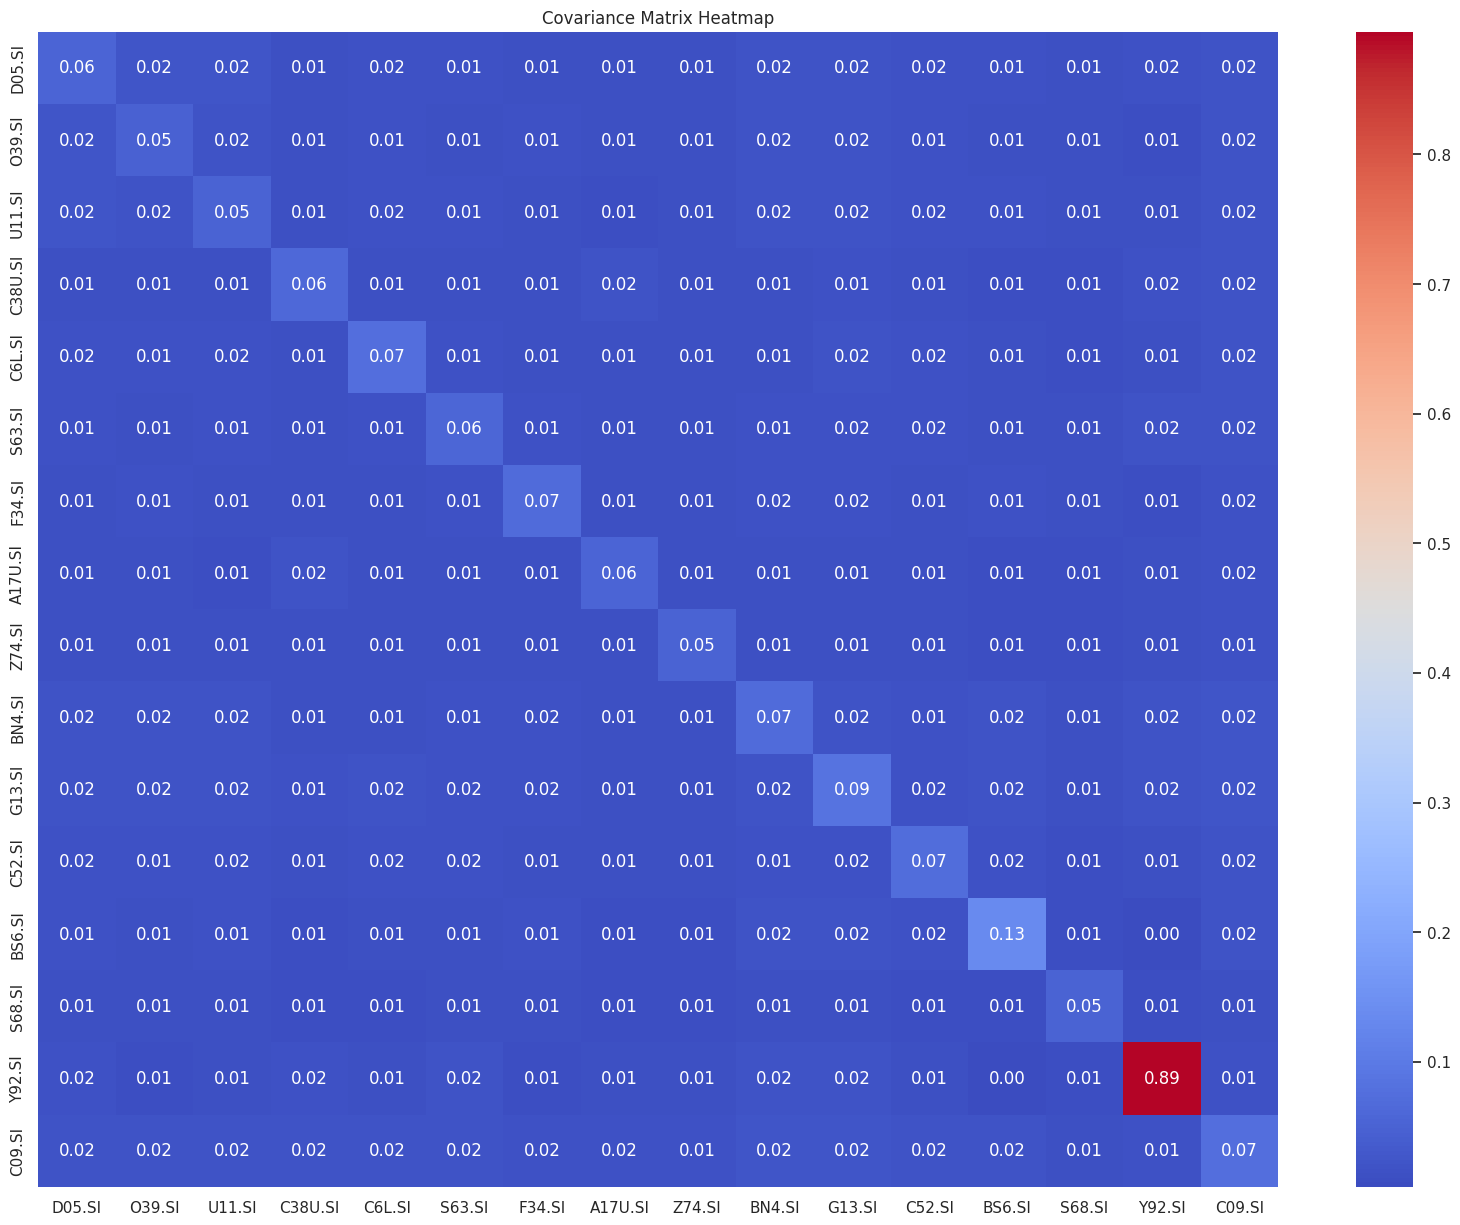

In [19]:
# Visualise our covariance matrix in the form of a heat map for all of our chosen stocks

sns.set(style="white")  # Set the background style

# Create a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(
    covariance,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    xticklabels=list(sector_mapper.keys()),
    yticklabels=list(sector_mapper.keys())
)

plt.title('Covariance Matrix Heatmap')
plt.show()

In [ ]:
# Dictionary to store our portfolio allocation for all 3 sector variations
portfolios = {}

#### Section 5.1: (Experiment 1) Fully Diversified Portfolio

For our fully diversified portfolio, we do not prescribe a bandwidth within which our sector portfolio allocation should fall for our portfolio. In other words, our sector upper and lower will take on the following values irregardless of our sector of focus:

> Sector Lower: 0 (At least 0% of capital to the sector of interest)

> Sector Upper: 1.0 (Less than 100% of capital to the sector of interest)

Unfeasible solution (Tighter Constraints)

In [20]:
sector_lower = {
    "Finance": 0.01,
    "Real Estate": 0.01,
    "Transportation": 0.01,
    "Technology & Engineering": 0.01,
    "Industrial & Manufacturing": 0.01,
    "Consumer Goods & Services": 0.01,
    "Investment & Holdings": 0.01
}

sector_upper = {
    "Finance": 0.5,
    "Real Estate": 0.5,
    "Transportation": 0.5,
    "Technology & Engineering": 0.5,
    "Industrial & Manufacturing": 0.5,
    "Consumer Goods & Services": 0.5,
    "Investment & Holdings": 0.5
}

# Optimize for the maximal Sharpe ratio
ef = EfficientFrontier(mean, covariance) # Using the mean and covariance of our stocks during the backtesting period
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper) # Adding the sector constraint to our ef object
try:
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    performance_metrics = ef.portfolio_performance(verbose=True)

    # Extract individual metrics
    expected_annual_return, annual_volatility, sharpe_ratio = performance_metrics
    expected_annual_return_perc = expected_annual_return * 100
    annual_volatility_perc = annual_volatility * 100

    annual_regular_return_decimal = expected_annual_return
    annual_log_return = np.log(1 + annual_regular_return_decimal)
    annual_log_return_perc = annual_log_return * 100

    diversified_portfolio_metrics = {
        'annual_log_returns': annual_log_return_perc,
        'annual_regular_returns': expected_annual_return_perc,
        'annual_regular_std': annual_volatility_perc,
        'sharpe_ratio': sharpe_ratio
    }

    # Calculate the discrete allocation of each share
    latest_prices = stocks_data.iloc[-1]
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
    allocation, leftover = da.lp_portfolio()
    print(f"Discrete allocation performed with ${leftover:.2f} leftover")
    print(allocation)
    print("\nDiversified Portfolio Metics: \n", diversified_portfolio_metrics)
    portfolios['Diversified Portfolio'] = allocation
except Exception as e:
    print("Optimization error:", e)

Optimization error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


Unfeasible Solution (Looser Constraints)

In [22]:
sector_lower = {
    "Finance": 0.01,
    "Real Estate": 0.01,
    "Transportation": 0.01,
    "Technology & Engineering": 0.01,
    "Industrial & Manufacturing": 0.01,
    "Consumer Goods & Services": 0.01,
    "Investment & Holdings": 0.01
}

sector_upper = {
    "Finance": 0.99,
    "Real Estate": 0.99,
    "Transportation": 0.99,
    "Technology & Engineering": 0.99,
    "Industrial & Manufacturing": 0.99,
    "Consumer Goods & Services": 0.99,
    "Investment & Holdings": 0.99
}

# Optimize for the maximal Sharpe ratio
ef = EfficientFrontier(mean, covariance) # Using the mean and covariance of our stocks during the backtesting period
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper) # Adding the sector constraint to our ef object
try:
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    performance_metrics = ef.portfolio_performance(verbose=True)

    # Extract individual metrics
    expected_annual_return, annual_volatility, sharpe_ratio = performance_metrics
    expected_annual_return_perc = expected_annual_return * 100
    annual_volatility_perc = annual_volatility * 100

    annual_regular_return_decimal = expected_annual_return
    annual_log_return = np.log(1 + annual_regular_return_decimal)
    annual_log_return_perc = annual_log_return * 100

    diversified_portfolio_metrics = {
        'annual_log_returns': annual_log_return_perc,
        'annual_regular_returns': expected_annual_return_perc,
        'annual_regular_std': annual_volatility_perc,
        'sharpe_ratio': sharpe_ratio
    }

    # Calculate the discrete allocation of each share
    latest_prices = stocks_data.iloc[-1]
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
    allocation, leftover = da.lp_portfolio()
    print(f"Discrete allocation performed with ${leftover:.2f} leftover")
    print(allocation)
    print("\nDiversified Portfolio Metics: \n", diversified_portfolio_metrics)
    portfolios['Diversified Portfolio'] = allocation
except Exception as e:
    print("Optimization error:", e)

Optimization error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


Feasible Solution with loose constraints

In [ ]:
sector_lower = {
    "Finance": 0.0,
    "Real Estate": 0.0,
    "Transportation": 0.0,
    "Technology & Engineering": 0.0,
    "Industrial & Manufacturing": 0.0,
    "Consumer Goods & Services": 0.0,
    "Investment & Holdings": 0.0
}

sector_upper = {
    "Finance": 1.0,
    "Real Estate": 1.0,
    "Transportation": 1.0,
    "Technology & Engineering": 1.0,
    "Industrial & Manufacturing": 1.0,
    "Consumer Goods & Services": 1.0,
    "Investment & Holdings": 1.0
}

# Optimize for the maximal Sharpe ratio
ef = EfficientFrontier(mean, covariance) # Using the mean and covariance of our stocks during the backtesting period
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper) # Adding the sector constraint to our ef object
try:
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    performance_metrics = ef.portfolio_performance(verbose=True)

    # Extract individual metrics
    expected_annual_return, annual_volatility, sharpe_ratio = performance_metrics
    expected_annual_return_perc = expected_annual_return * 100
    annual_volatility_perc = annual_volatility * 100

    annual_regular_return_decimal = expected_annual_return
    annual_log_return = np.log(1 + annual_regular_return_decimal)
    annual_log_return_perc = annual_log_return * 100

    diversified_portfolio_metrics = {
        'annual_log_returns': annual_log_return_perc,
        'annual_regular_returns': expected_annual_return_perc,
        'annual_regular_std': annual_volatility_perc,
        'sharpe_ratio': sharpe_ratio
    }

    # Calculate the discrete allocation of each share
    latest_prices = stocks_data.iloc[-1]
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
    allocation, leftover = da.lp_portfolio()
    print(f"Discrete allocation performed with ${leftover:.2f} leftover")
    print(allocation)
    print("\nDiversified Portfolio Metics: \n", diversified_portfolio_metrics)
    portfolios['Diversified Portfolio'] = allocation
except Exception as e:
    print("Optimization error:", e)

Expected annual return: 41.1%
Annual volatility: 35.6%
Sharpe Ratio: 1.10
Discrete allocation performed with $0.65 leftover
{'D05.SI': 11622, 'F34.SI': 13744, 'A17U.SI': 59593, 'G13.SI': 1, 'C52.SI': 2, 'BS6.SI': 13707, 'S68.SI': 6130, 'Y92.SI': 526351}

Diversified Portfolio Metics: 
 {'annual_log_returns': 34.41467181023034, 'annual_regular_returns': 41.07856081111722, 'annual_regular_std': 35.640743250897565, 'sharpe_ratio': 1.096457515939516}


#### Section 5.3: (Experiment 2) Growth-Oriented Portfolio

In [ ]:
sector_lower = {
    "Finance": 0.0,
    "Real Estate": 0.05,
    "Transportation": 0.35,
    "Technology & Engineering": 0.05,
    "Industrial & Manufacturing": 0.05,
    "Consumer Goods & Services": 0.35,
    "Investment & Holdings": 0.0
}

sector_upper = {
    "Finance": 1.0,
    "Real Estate": 0.7,
    "Transportation": 1.0,
    "Technology & Engineering": 1.0,
    "Industrial & Manufacturing": 0.8,
    "Consumer Goods & Services": 0.6,
    "Investment & Holdings": 0.6
}

ef = EfficientFrontier(mean, covariance)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
try:
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    ef.portfolio_performance(verbose=True)

    # Calculate the discrete allocation of each share
    latest_prices = stocks_data.iloc[-1]
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
    allocation, leftover = da.lp_portfolio()
    print(f"Discrete allocation performed with ${leftover:.2f} leftover")
    print(allocation)
    portfolios['Growth Oriented Portfolio'] = allocation
except Exception as e:
    print("Optimization error:", e)

Expected annual return: 49.1%
Annual volatility: 48.8%
Sharpe Ratio: 0.96
Discrete allocation performed with $12.03 leftover
{'C38U.SI': 1, 'C6L.SI': 17691, 'S63.SI': 15575, 'F34.SI': 1, 'A17U.SI': 19296, 'Z74.SI': 1, 'G13.SI': 3, 'C52.SI': 217118, 'BS6.SI': 38318, 'Y92.SI': 756283}


#### Section 5.3: (Experiment 3) Defensive Portfolio

In [ ]:
sector_lower = {
    "Finance": 0.0,
    "Real Estate": 0.15,
    "Consumer Goods & Services": 0.0,
    "Investment & Holdings": 0.0,
    "Technology & Engineering": 0.05,
    "Industrial & Manufacturing": 0.05,
    "Transportation": 0.05
}

sector_upper = {
    "Finance": 0.50,
    "Real Estate": 0.3,
    "Consumer Goods & Services": 0.05,
    "Investment & Holdings": 0.2,
    "Technology & Engineering": 0.30,
    "Industrial & Manufacturing": 0.20,
    "Transportation": 0.10
}

ef = EfficientFrontier(mean, covariance)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
try:
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    ef.portfolio_performance(verbose=True)

    # Calculate the discrete allocation of each share
    latest_prices = stocks_data.iloc[-1]
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
    allocation, leftover = da.lp_portfolio()
    print(f"Discrete allocation performed with ${leftover:.2f} leftover")
    print(allocation)
    portfolios['Defensive Portfolio'] = allocation
except Exception as e:
    print("Optimization error:", e)


Expected annual return: 12.2%
Annual volatility: 15.4%
Sharpe Ratio: 0.66
Discrete allocation performed with $5.05 leftover
{'D05.SI': 10957, 'O39.SI': 733, 'U11.SI': 974, 'C38U.SI': 27413, 'S63.SI': 15572, 'A17U.SI': 95283, 'G13.SI': 1, 'C52.SI': 42434, 'BS6.SI': 38310, 'S68.SI': 13104, 'Y92.SI': 75641}


### Section 6: Portfolio Performance Evaluation

#### Section 6.1: Benchmark Metrics

In [ ]:
# Fetch benchmark data
benchmark_data = yf.Ticker(benchmark).history(start=backtesting_start, end=backtesting_end).Close
benchmark_log_returns = np.log(benchmark_data / benchmark_data.shift(1)).dropna()

# Calculate benchmark metrics
annual_log_return_benchmark = benchmark_log_returns.mean() * 252
annual_regular_return_benchmark = (np.exp(annual_log_return_benchmark) - 1) * 100
daily_regular_std_benchmark = (np.exp(benchmark_log_returns) - 1).std()
annual_regular_std_benchmark = daily_regular_std_benchmark * (252 ** 0.5) * 100
sharpe_ratio_benchmark = annual_regular_return_benchmark / annual_regular_std_benchmark

print("Benchmark Annual Log Return: ", annual_log_return_benchmark)
print("Benchmark Annual Regular Return: ", annual_regular_return_benchmark)
print("Benchmark Daily Standard Deviation: ", daily_regular_std_benchmark)
print("Benchmark Annual Standard Deviation: ", annual_regular_std_benchmark)
print("Benchmark Sharpe Ratio: ", sharpe_ratio_benchmark)

Benchmark Annual Log Return:  -0.015844445310449724
Benchmark Annual Regular Return:  -1.5719582417755285
Benchmark Daily Standard Deviation:  0.006042345044976208
Benchmark Annual Standard Deviation:  9.59192539479026
Benchmark Sharpe Ratio:  -0.16388349336300287


#### Section 6.2: Performance Plot (Portfolios vs Benchmark)

**Computing Portfolio Returns using test data**

In [ ]:
def computing_portfolio_log_returns(stocks, start, end, portfolios):
    """
    Computes the individual portfolio returns based on the allocation

    Parameters:
    stocks (list): A list of all the ticker symbols
    start, end (str): Start and end dates of the analysis
    portfolios (dict): A dictionary containing the allocation of shares for each portfolio
    """
    portfolio_log_returns = pd.DataFrame()
    for portfolio, allocation in portfolios.items():
        # Assign the share allocation count to each stock
        shares = []
        for ticker in stocks:
            if ticker not in list(allocation.keys()):
                shares.append(0)
            else:
                shares.append(allocation[ticker])

        # Retrieve the historical share prices for test data and compute the log returns (Approach B)
        test_data = closing_price_dataframe(stocks, start, end)
        test_data['portfolio_value'] = test_data.dot(shares) # Derive the total portfolio value for each day
        test_data['portfolio_log_returns'] = np.log(test_data['portfolio_value'] / test_data['portfolio_value'].shift(1))
        portfolio_log_returns[f'{portfolio} Log Returns'] = test_data['portfolio_log_returns']

    return portfolio_log_returns


# Add the base portfolio to the dictionary
portfolios['Base Portfolio'] = base_portfolio

portfolios_returns = computing_portfolio_log_returns(stocks, backtesting_start, backtesting_end, portfolios)
portfolios_returns = portfolios_returns.dropna()
portfolios_returns

,Diversified Portfolio Log Returns,Growth Oriented Portfolio Log Returns,Defensive Portfolio Log Returns,Base Portfolio Log Returns
Date,,,,
2023-01-04,-0.002179,-0.004541,-0.002147,-0.002180
2023-01-05,0.019086,0.010547,0.014746,0.019084
2023-01-06,-0.006003,0.000125,-0.008438,-0.006003
2023-01-09,0.021629,0.015906,0.015419,0.021628
2023-01-10,-0.013480,-0.005542,-0.014560,-0.013480
...,...,...,...,...
2023-10-25,-0.000563,0.004661,-0.004733,-0.000565
2023-10-26,-0.000044,0.000832,-0.000487,-0.000044
2023-10-27,0.003535,-0.001128,0.000307,0.003534


In [ ]:
def portfolio_comparison_with_benchmark(portfolios_dataframe, benchmark, benchmark_metrics, start, end):
    """
    Compares multiple portfolios with a benchmark.

    Parameters:
    portfolios_dataframe (DataFrame): DataFrame with portfolio values.
    benchmark (str): Ticker symbol of the benchmark.
    benchmark_metrics (dict): A dictionary containing pre-calculated benchmark metrics (annual regular return, std, Sharpe ratio).
    start (str): Start date for the analysis.
    end (str): End date for the analysis.
    """
    portfolios_dataframe = portfolios_dataframe.dropna()

    benchmark_data = yf.Ticker(benchmark).history(start=start, end=end).Close
    benchmark_log_returns = np.log(benchmark_data / benchmark_data.shift(1)).dropna()

    # Define the plot parameters
    plt.figure(figsize=(20, 10))

    # Plot the benchmark
    cumulative_returns_benchmark = benchmark_log_returns.cumsum()
    plt.plot(cumulative_returns_benchmark, label=f"{benchmark} Benchmark")

    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title('Portfolio Performance vs Benchmark')

    for portfolio_name in portfolios_dataframe.columns:
        # Calculate log returns for the portfolio
        portfolio_log_returns = portfolios_dataframe[[portfolio_name]].dropna()
        portfolio_log_returns.index = pd.to_datetime(portfolio_log_returns.index, utc=True).tz_convert("Asia/Singapore").normalize()

        if "Log Returns" in portfolio_name:
            # Remove "Log Returns" and strip any extra spaces
            portfolio_name = portfolio_name.replace("Log Returns", "").strip()

        # Calculate portfolio metrics
        annual_log_return_portfolio = portfolio_log_returns.mean() * 252
        annual_regular_return_portfolio = (np.exp(annual_log_return_portfolio) - 1) * 100
        daily_regular_std_portfolio = (np.exp(portfolio_log_returns) - 1).std()
        annual_regular_std_portfolio = daily_regular_std_portfolio * (252 ** 0.5) * 100
        sharpe_ratio_portfolio = annual_regular_return_portfolio / annual_regular_std_portfolio

        # Calculate Beta for Treynor Ratio
        slope, _, _, _, _ = linregress(benchmark_log_returns.values, portfolio_log_returns.values.flatten())
        beta_portfolio = slope

        # Treynor Ratio
        treynor_ratio = annual_regular_return_portfolio / beta_portfolio
        # Treynor Ratio for Benchmark (Benchmark beta is assumed to be 1)
        treynor_ratio_benchmark = benchmark_metrics['annual_regular_return']

        # Information Ratio
        excess_returns = portfolio_log_returns.values - benchmark_log_returns.values
        information_ratio = excess_returns.mean() / excess_returns.std()

        # Calmar Ratio
        max_drawdown = (portfolio_log_returns.cumsum().expanding().max() - portfolio_log_returns.cumsum()).max()
        calmar_ratio = annual_regular_return_portfolio / max_drawdown
        max_drawdown_benchmark = (benchmark_log_returns.cumsum().expanding().max() - benchmark_log_returns.cumsum()).max()
        calmar_ratio_benchmark = benchmark_metrics['annual_regular_return'] / max_drawdown_benchmark

        # Print comparison
        print(f"--- {portfolio_name} vs {benchmark} ---")
        print(f"Annual Regular Return: {portfolio_name} = {annual_regular_return_portfolio[0]}%, Benchmark = {benchmark_metrics['annual_regular_return']}")
        print(f"Annual Regular Std Dev: {portfolio_name} = {annual_regular_std_portfolio[0]}%, Benchmark = {benchmark_metrics['annual_std']}")
        print(f"Sharpe Ratio: {portfolio_name} = {sharpe_ratio_portfolio[0]}, Benchmark = {benchmark_metrics['sharpe_ratio']}")
        print(f"Information Ratio: {portfolio_name} = {information_ratio}")
        print(f"Treynor Ratio: {portfolio_name} = {treynor_ratio[0]}, Benchmark = {treynor_ratio_benchmark}")
        print(f"Calmar Ratio: {portfolio_name} = {calmar_ratio[0]}, Benchmark = {calmar_ratio_benchmark}\n")


        # Plot cumulative returns for portfolio
        cumulative_returns_portfolio = portfolio_log_returns.cumsum()
        plt.plot(cumulative_returns_portfolio, label=f"{portfolio_name}")
        plt.legend()



--- Diversified Portfolio vs ES3.SI ---
Annual Regular Return: Diversified Portfolio = -6.503954541329282%, Benchmark = -1.5719582417755285
Annual Regular Std Dev: Diversified Portfolio = 11.243812491680263%, Benchmark = 9.59192539479026
Sharpe Ratio: Diversified Portfolio = -0.5784474390818783, Benchmark = -0.16388349336300287
Information Ratio: Diversified Portfolio = -0.021981882766091566
Treynor Ratio: Diversified Portfolio = -7.7960908777479565, Benchmark = -1.5719582417755285
Calmar Ratio: Diversified Portfolio = -51.44147160220907, Benchmark = -19.728436611914148

--- Growth Oriented Portfolio vs ES3.SI ---
Annual Regular Return: Growth Oriented Portfolio = -3.20711325827987%, Benchmark = -1.5719582417755285
Annual Regular Std Dev: Growth Oriented Portfolio = 12.65791397406724%, Benchmark = 9.59192539479026
Sharpe Ratio: Growth Oriented Portfolio = -0.2533682299350752, Benchmark = -0.16388349336300287
Information Ratio: Growth Oriented Portfolio = -0.006665001883775512
Treynor R

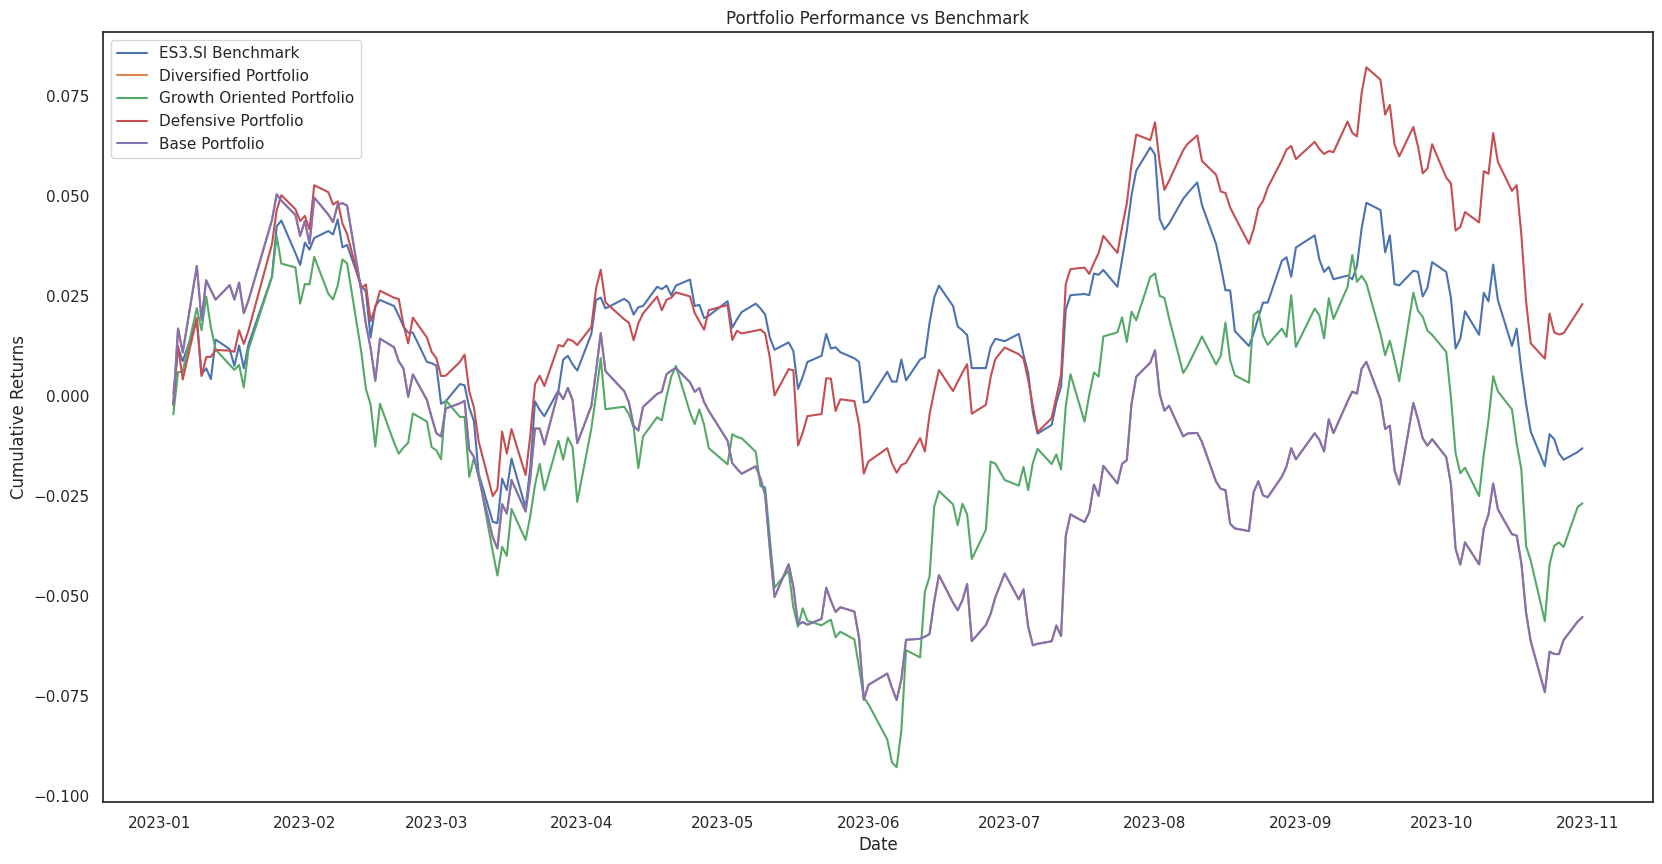

In [ ]:
# Prepare benchmark metrics in a dictionary
benchmark_metrics = {
    'annual_regular_return': annual_regular_return_benchmark,
    'annual_std': annual_regular_std_benchmark,
    'sharpe_ratio': sharpe_ratio_benchmark
}

portfolio_comparison_with_benchmark(portfolios_returns, benchmark, benchmark_metrics, backtesting_start, backtesting_end)